###### R√©seaux de chaleur urbains - Cas d'√©tude

***Auteur : Charlotte Gressel, √©tudiante ing√©nieur √† l'√©cole des Mines, 2025***

## Sous-cas d'√©tude : Classement selon la distance √† l'usine √† chaleur - Usine n¬∞1

Ce notebook √©tudie le cas d'√©tude de la ville de Grandvilliers. Dans les notebook pr√©c√©dents, nous appliquons l'agorithme selon un classement des b√¢timents tr√®s pr√©cis: leur demande en chaleur dans l'ordre d√©croissant. Dans ce sous-cas d'√©tude, nous allons √©tudier les cons√©quences d'un **classement selon la distance √† l'usine √† chaleur**, et plus la demande en chaleur de chaque b√¢timent. 

Nous avons √©galement ins√©r√© un algorithme permettant de calculer le `lambda_` optimal permettant de choisir la densit√© lin√©ique maximale pour le r√©seau. Si elle est inf√©rieure √† 1.5 GWh/km, e r√©seau n'est pas √©conomique viable.


*Chargement des modules :*

In [1]:
from shapely.geometry import shape, LineString, MultiLineString, Point, Polygon
from shapely.ops import nearest_points
import fiona

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import geopandas as gpd

## Extraction et filtrage des donn√©es g√©ographiques et √©nerg√©tiques

Dans cette partie, deux principaux fichiers sont √† l'√©tude : 
- Un fichier des b√¢timents pour un d√©partement choisi, t√©l√©charg√© sur le site BD TOPO¬Æ de G√©oservices (base BDNB) au format Geopackage
- Un fichier des routes pour un d√©partement choisi, t√©l√©charg√© sur le site BD CARTO¬Æ de G√©oservices au format Geopackage

Elles ont ensuite √©t√© exploit√©s avec le logiciel GQIS afin d'extraire et exporter uniquement les attributs √† √©tudier, √† savoir `B√¢timents groupes > Classe DPE (DPE r√©els)` pour les b√¢timents et `BDT_3-~1 ‚Äî troncon_de_route` pour les routes. 

Il est important de souligner que l'√©tude est faite √† partir de donn√©es **d√©partementales** et non nationales, notamment pour des raisons de format des donn√©es t√©l√©chargeables et du temps de calcul. Le d√©partement choisi dans l'√©tude qui suit est l'Oise.

In [3]:
# Chemins vers les fichiers GeoPackage
buildings_file = "C:/Users/charl/OneDrive/Documents/Documents/4. Mines/2. EFFINERSYS/R√©seaux de chaleur et transition √©nerg√©tique/test60/bat_oise.gpkg"
roads_file = "C:/Users/charl/OneDrive/Documents/Documents/4. Mines/2. EFFINERSYS/R√©seaux de chaleur et transition √©nerg√©tique/test60/routes_oise.gpkg"

### S√©lection de la zone d'√©tude

On commence par s√©lectionner le lieu que l'on souhaite √©tudier √† partir de l'attribut `code_commune_insee`.

**Attention!** Le `code_commune_insee` n'est pas le m√™me que le code postal connu de tous. Il est donc n√©cessaire de rechercher sur le site de l'Insee le code commune de la zone √† √©tudier.

Ici, nous √©tudierons la communes de **Grandvilliers (60286)**.

In [5]:
# Demande du code postal de la ville/lieu √† √©tudier

def ask_code_commune():
    while True:
        code_postal = input("Veuillez entrer le code postal de la commune que vous souhaitez √©tudier : ")
        
        # Validation simple : v√©rifier que le code postal contient exactement 5 chiffres
        if code_postal.isdigit() and len(code_postal) == 5:
            return code_postal
        else:
            print("Le code commune Insee doit contenir exactement 5 chiffres. Veuillez r√©essayer.")

def find_libelle_commune(code_commune):
    buildings_fiona = fiona.open(buildings_file)

    libelle_commune = None
    for building in buildings_fiona:
        building_properties = building["properties"]
        if building_properties["code_commune_insee"] == code_commune:
            libelle_commune = building_properties["libelle_commune_insee"]
            break  # On arr√™te d√®s qu'on trouve un match
    
    buildings_fiona.close()

    return libelle_commune

code_comm_insee = ask_code_commune()
libelle_commune = find_libelle_commune(code_comm_insee)

print(f"Code commune Insee retenu : {code_comm_insee}")
print(f"Commune s√©lectionn√©e : {libelle_commune}")

Veuillez entrer le code postal de la commune que vous souhaitez √©tudier :  60286


Code commune Insee retenu : 60286
Commune s√©lectionn√©e : Grandvilliers


### S√©lection des b√¢timents et des routes

#### 1<sup>er</sup> filtrage: s√©lection des b√¢timents et des routes de la commune choisie

On commence par s√©lectionner les b√¢timents de la commune choisie. Les b√¢timents devront √©galement r√©pondre √† un crit√®re de hauteurs sup√©rieur √† 3 m√®tres. 

Cette op√©ration est la plus chronophage en raison du nombre important de b√¢timents √† parcourir (390 581 ici).

In [7]:
# Extraction des b√¢timents
buildings_fiona = fiona.open(buildings_file)

buildings = []  # b√¢timents qui seront consid√©r√©s pour le RCU

for building in tqdm(buildings_fiona, desc="Extraction des b√¢timents", unit="b√¢timent"):
    properties = building["properties"]
    
    # V√©rification des conditions sur les propri√©t√©s
    if (properties["code_commune_insee"] == code_comm_insee and
        properties["s_geom_groupe"] is not None and
        properties["ffo_bat_annee_construction"] is not None and
        properties["bdtopo_bat_hauteur_mean"] is not None and
        properties["bdtopo_bat_hauteur_mean"] >= 3 and
        properties["dpe_mix_arrete_classe_conso_energie_arrete_2012"] is not None and
        properties["dpe_mix_arrete_classe_conso_energie_arrete_2012"] != "N"):
        buildings.append(building)

buildings_fiona.close()

print(len(buildings), "b√¢timents ont √©t√© retenus.")

Extraction des b√¢timents: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 390581/390581 [03:58<00:00, 1638.47b√¢timent/s]

153 b√¢timents ont √©t√© retenus.


On s√©lectionne ensuite les routes de la commune choisie gr√¢ce √† la commune qui se trouve √† droite et √† gauche de la route. On ne conserve que les routes "int√©rieures", √† savoir celles dont la commune √† droite et √† gauche est celle qui porte le code commune Insee s√©lectionn√©.

In [8]:
# Extraction des routes
roads_fiona = fiona.open(roads_file)

roads = []

print("Analyse des routes en cours...")
for road in tqdm(roads_fiona, desc="Progression", unit="route"):
    properties = road["properties"]

    # Condition pour filtrer les routes
    if (properties["insee_commune_gauche"] == code_comm_insee) and \
       (properties["insee_commune_droite"] == code_comm_insee):
        
        roads.append(road)

# Fermeture du fichier et affichage des r√©sultats
nb_roads = len(roads)
roads_fiona.close()

print(f"{nb_roads} routes ont √©t√© retenues.")

Analyse des routes en cours...


Progression: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 239444/239444 [01:09<00:00, 3455.58route/s]


350 routes ont √©t√© retenues.


Visualisons ce premier filtrage sur un graphe.

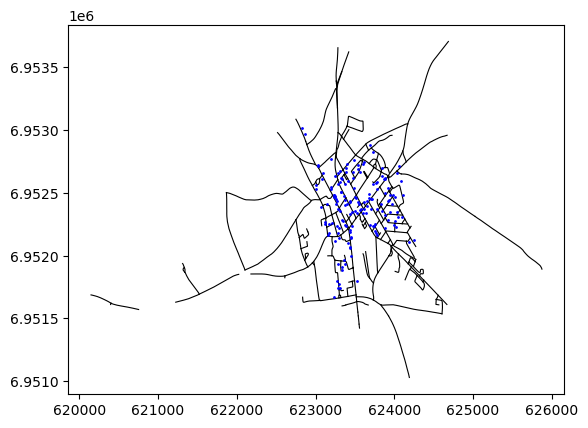

In [20]:
# Trac√© des routes et positionnement des noeuds de route
for road in roads:
    coordinates = road["geometry"]["coordinates"]  # R√©cup√®re les coordonn√©es

    coordinates = [coordinates]  # Transformer en liste pour it√©ration uniforme

    for segment in coordinates:  # It√©rer sur chaque segment de la route
        # Extraire les coordonn√©es (g√©rer 2D ou 3D)
        x, y = zip(*[(x, y) for x, y, z in segment])
        
        # Trac√© du segment de la route
        plt.plot(x, y, color="black", linewidth=0.8)

# Repr√©sentation des b√¢timents par des points
for building in buildings:
    polygon_batiment = shape(building["geometry"])
    # Coordonn√©es du centre du b√¢timent
    centroid = polygon_batiment.centroid
    plt.plot(centroid.x, centroid.y, 'bo', markersize=1)

#### 2<sup>√®me</sup> filtrage : S√©lection des routes proches des b√¢timents (optionnel)

Cette √©tape permet une meilleure visualisation du r√©seau afin de mieux positionner l'usine √† chaleur.

In [11]:
building_polygons = [shape(building["geometry"]) for building in buildings]

filtered_roads = []
distance_max = 500  # Distance maximale de 500 m√®tres (√† modifier si besoin)

# Parcourir uniquement les routes d√©j√† pr√©-s√©lectionn√©es
for road in roads:
    road_geom = shape(road["geometry"])

    # V√©rification si la route est proche d'un b√¢timent
    if any(road_geom.distance(building_geom) <= distance_max for building_geom in building_polygons):
        filtered_roads.append(road)

# Affichage du nombre de routes retenues apr√®s filtrage
roads = filtered_roads
nb_roads = len(roads)
print(f"{nb_roads} routes sont proches des b√¢timents (moins de {distance_max}m).")

324 routes sont proches des b√¢timents (moins de 500m).


### Affichage du quartier d'√©tude final :

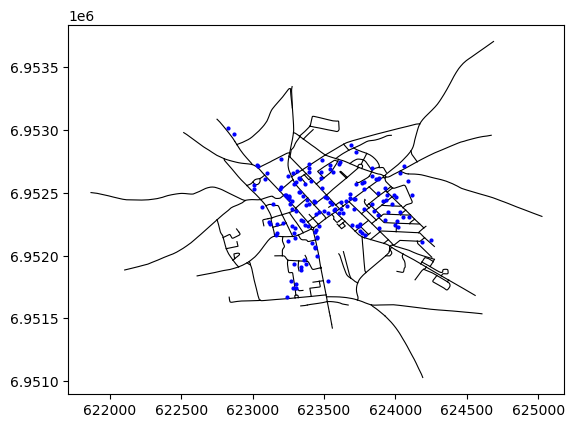

In [13]:
for road in roads:
    coordinates = road["geometry"]["coordinates"]  # R√©cup√®re les coordonn√©es

    coordinates = [coordinates]  # Transformer en liste pour it√©ration uniforme

    for segment in coordinates:  # It√©rer sur chaque segment de la route
        # Extraire les coordonn√©es (g√©rer 2D ou 3D)
        x, y = zip(*[(x, y) for x, y, z in segment])
        
        # Trac√© du segment de la route
        plt.plot(x, y, color="black", linewidth=0.8)

# Repr√©sentation des b√¢timents par des points avec num√©rotation
for building in buildings:  # D√©marre la num√©rotation √† 1
    polygon_batiment = shape(building["geometry"])
    centroid = polygon_batiment.centroid  # Coordonn√©es du centre du b√¢timent

    # Trac√© du point central du b√¢timent
    plt.plot(centroid.x, centroid.y, 'bo', markersize=2)

#### D√©finition de l'Usine √† chaleur

Nous recherchons √† pr√©sent une zone o√π positionner l'usine √† chaleur. Dans ce cas d'√©tude, nous ferons l'hypoth√®se que l'usine √† chaleur √† proximit√© des b√¢timents du quartier d'√©tude, mais √©galement d'un champs dans lequel on istallera hypoth√©tiquement des panneaux solaires. 

Une photo a√©rienne de la ville de Chaumont-en-Vexin nous permet d'identifier une zone potentielle r√©pondant √† ces crit√®res :

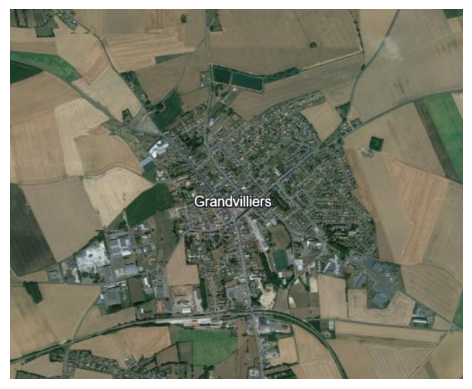

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Utilisation d'un raw string (r"...")
chemin_image = r"C:\Users\charl\OneDrive\Documents\Documents\4. Mines\2. EFFINERSYS\R√©seaux de chaleur et transition √©nerg√©tique\Image_Grandvilliers.png"

# Charger et afficher l'image
img = mpimg.imread(chemin_image)
plt.imshow(img)
plt.axis('off')  # Masquer les axes
plt.show()

Nous d√©cidons alors de positionner arbitrairement notre usine √† chaleur √† proximit√© du champs en haut au centre. On s√©lectionne les coordonn√©es manuellement, en se mettant √† l'√©chelle du graphe pr√©c√©dent.

In [342]:
from fiona.model import Feature
from shapely.geometry import Point, mapping

# üîµ S√âLECTION DE L'USINE √Ä CHALEUR üîµ

def choisir_usine():
    print("Veuillez choisir une usine parmi les trois disponibles :")
    print("1 - Usine 1 (Longitude: 623100, Latitude: 6.9522 * 1e6)")
    print("2 - Usine 2 (Longitude: 624100, Latitude: 6.9527 * 1e6)")
    print("3 - Usine 3 (Longitude: 623500, Latitude: 6.95285 * 1e6)")
    
    choix = input("Entrez le num√©ro de l'usine (1, 2 ou 3) : ")
    
    usines = {
        "1": (623100, 6.9523 * 1e6),
        "2": (624100, 6.9527 * 1e6),
        "3": (623500, 6.95285 * 1e6)
    }
    
    return usines.get(choix, usines["1"])  # Par d√©faut, Usine 1

# R√©cup√©ration des coordonn√©es en fonction du choix de l'utilisateur
longitude, latitude = choisir_usine()
new_point = Point(longitude, latitude)  # Cr√©ation du point Shapely

# D√©finition des propri√©t√©s du nouveau b√¢timent
heat_plant_properties = {
    "code_commune_insee": "XXXXX",  # Remplacez par la valeur appropri√©e
    "s_geom_groupe": 300,  # Surface arbitraire en m¬≤
    "ffo_bat_annee_construction": 2000,  # Ann√©e fictive
    "bdtopo_bat_hauteur_mean": 20,  # Hauteur arbitraire en m√®tres
    "dpe_mix_arrete_classe_conso_energie_arrete_2012": "A"  # On part du principe que l'usine √† chaleur consomme tr√®s peu d'√©nergie par rapport au fait qu'elle en produise
}

# Cr√©er l'objet Feature pour l'usine √† chaleur
heat_plant = Feature(
    id=None,  # ID automatique ou d√©fini manuellement
    geometry=mapping(new_point),  # Conversion de la g√©om√©trie Shapely vers GeoJSON
    properties=heat_plant_properties  # Propri√©t√©s associ√©es
)

Veuillez choisir une usine parmi les trois disponibles :
1 - Usine 1 (Longitude: 623100, Latitude: 6.9522 * 1e6)
2 - Usine 2 (Longitude: 624100, Latitude: 6.9527 * 1e6)
3 - Usine 3 (Longitude: 623500, Latitude: 6.95285 * 1e6)


Entrez le num√©ro de l'usine (1, 2 ou 3) :  2


<u>Affichage de l'usine √† chaleur : </u>

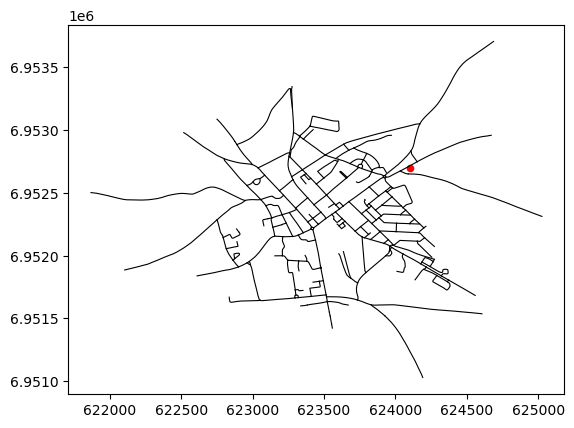

In [344]:
for road in roads:
    coordinates = road["geometry"]["coordinates"]  # R√©cup√®re les coordonn√©es

    coordinates = [coordinates]  # Transformer en liste pour it√©ration uniforme

    for segment in coordinates:  # It√©rer sur chaque segment de la route
        # Extraire les coordonn√©es (g√©rer 2D ou 3D)
        x, y = zip(*[(x, y) for x, y, z in segment])
        
        # Trac√© du segment de la route
        plt.plot(x, y, color="black", linewidth=0.8)

heat_point = shape(heat_plant["geometry"])
plt.scatter(heat_point.x, heat_point.y, color="red", s=20, label="Usine √† chaleur")

#### 3<sup>√®me</sup> filtrage : S√©lection des b√¢timents connectables


##### Calcul de la consommation des b√¢timents et s√©lection du plus grand consommateur

Nous nous basons sur l'attribut `dpe_class_to_consumption` pour √©valuer la consommation des b√¢timents. La lettre attribu√©e √† chaque b√¢timent est associ√©e √† sa consommation √©nerg√©tique moyenne en kWh/m¬≤/an.

Nous estimons alors la consommation √©nerg√©tique annuelle moyenne de chaque b√¢timent √† partir de leurs DPE moyen, surface et hauteur, par la formule suivante :

$$
Q \approx DPE \times S \times E\left(\frac{h}{h_0}\right)
$$

O√π $h_0 = 3m$ et o√π $E$ est la fonction partie enti√®re, afin d'introduire une estimation du nombre d'√©tages pour chaque b√¢timent.

In [348]:
# Calcul des demandes en chaleur pour tous les b√¢timents retenus

# Fonction de mapping de la classe DPE √† la consommation √©nerg√©tique (kWh/m¬≤/an)
def dpe_class_to_consumption(dpe_class):
    dpe_map = {
        "A": 50,  # Consommation max pour A est 50
        "B": 90,  # Consommation max pour B est 90
        "C": 150, # Consommation max pour C est 150
        "D": 230, # Consommation max pour D est 230
        "E": 330, # Consommation max pour E est 330
        "F": 450, # Consommation max pour F est 450
        "G": 500  # On consid√®re 500 comme une valeur repr√©sentative pour G (au-del√† de 450)
    }
    return dpe_map[dpe_class]  # Pas besoin de valeur par d√©faut ici

# Calcul des demandes en chaleur pour tous les b√¢timents retenus
h_0 = 3  # m√®tres, taille d'un √©tage
nb_buildings = len(buildings)
heat_demands = np.zeros(nb_buildings)

for k, building in enumerate(buildings):
    properties = building["properties"]
    
    # Conversion de la classe DPE en consommation d'√©nergie
    dpe_class = properties["dpe_mix_arrete_classe_conso_energie_arrete_2012"]  # Aucun d√©faut n√©cessaire
    dpe_consumption = dpe_class_to_consumption(dpe_class)
    
    # Calcul de la demande en chaleur en kWh/an
    Q = dpe_consumption * properties["s_geom_groupe"] * int(properties["bdtopo_bat_hauteur_mean"] / h_0)
    heat_demands[k] = Q

In [349]:
# CLASSEMENT suivant les CONSOMMATIONS DECROISSANTES
sorted_index = np.argsort(heat_demands)[::-1]
heat_demands = np.sort(heat_demands)[::-1]
buildings = [buildings[index] for index in sorted_index]

##### D√©termination des b√¢timents connectables

Le crit√®re de connexion est d√©fini sur le site **France Chaleur** : au-del√† de $30kW$, un b√¢timent doit dans la plupart des cas √™tre consid√©r√© pour le trac√© du r√©seau de chaleur.

La puissance thermique maximale demand√©e par les habitations est estim√©e gr√¢ce √† une technique d√©finie dans la section suivante. On r√©alisera alors le filtrage des b√¢timents selon ce crit√®re.

Ce proc√©d√© permet de trouver le compromis entre une demande raccord√©e maximale en premier plan et un nombre de b√¢timents raccord√© minimal afin de limiter les co√ªts.

##### Estimation de la consommation √©nerg√©tique annuelle moyenne

Afin de r√©aliser la simulation d'un r√©seau de chaleur avec le logiciel Dymola, il faut estimer leurs demandes instantan√©es tout au long de l'ann√©e. Pour cela, nous utilisons la m√©thode d√©crite dans les sections suivantes.

Nous utilisons des profils typiques de demande en chaleur. Nous disposons de trois fichiers correspondant aux courbes typiques des b√¢timents construits durant les p√©riodes suivantes :
* Avant 1989 (exclu) : `RT_1974_Treated.csv` (il s'agit en r√©alit√© des normes des b√¢timents construits entre 1974 et 1989);
* Entre 1989 (inclus) et 2005 (exclu) : `RT_1989_Trated.csv` (il s'agit des normes des b√¢timents construits entre 1989 et 2005);
* Apr√®s 2005 (inclus) : `RT_2005_Treated.csv`.

Il s'agit de timeseries que nous allons manipuler avec `pandas`.

In [355]:
heat_profile_1974 = pd.read_csv("C:/Users/charl/OneDrive/Documents/Documents/4. Mines/2. EFFINERSYS/R√©seaux de chaleur et transition √©nerg√©tique/code/data/RT_1974_Treated.csv", index_col=0)
heat_profile_1989 = pd.read_csv("C:/Users/charl/OneDrive/Documents/Documents/4. Mines/2. EFFINERSYS/R√©seaux de chaleur et transition √©nerg√©tique/code/data/RT_1989_Treated.csv", index_col=0)
heat_profile_2005 = pd.read_csv("C:/Users/charl/OneDrive/Documents/Documents/4. Mines/2. EFFINERSYS/R√©seaux de chaleur et transition √©nerg√©tique/code/data/RT_2005_Treated.csv", index_col=0)

On calcule ensuite la puissance thermique demand√©e pour chaque b√¢timent √† partir de la formule suivante:
$$
\Phi_{th} = D_m \cdot c_p \cdot (T_{d√©part} - T_{retour})
$$

Puis on calcule le coefficient de demande en chaleur associ√© √† chaque b√¢timent:
$$
\alpha_k = \frac{Q_{total}}{\left( \sum_{1 \, \text{an}} \Phi_{th,ref} \right) \cdot \Delta t}
$$


In [357]:
# Tableau des coefficients alpha
heat_profile_coeff_tab = np.zeros(nb_buildings)

# Constantes
cp_water = 4180 # J/K/kg
delta_t = 1 # h (l'√©nergie est en kWh)

# Initialisation
sum_power = np.zeros(3)

# Fonction pour cat√©goriser les b√¢timents suivant leur ann√©e de construction
def categorize(building):
    construction_date = building["properties"]["ffo_bat_annee_construction"]
    # 0 : avant 1989 exclu
    if construction_date < 1989:
        return 0
    # 1 : entre 1989 inclus et 2005 exclu
    elif 1989 <= construction_date < 2005:
        return 1
    # 2 : apr√®s 2005 exclu
    else:
        return 2
    
df_tab = [heat_profile_1974, heat_profile_1989, heat_profile_2005]

# Calcul de la colonne des puissances dans les dataframes de r√©f√©rence
def add_power_column(df):
    df.Puissance = cp_water * df.Debit_eau * (df.Tdepart - df.Tretour)
    
for k, df in enumerate([heat_profile_1974, heat_profile_1989, heat_profile_2005]):
    # Ajout de la colonne puissance
    add_power_column(df)
    # Calcul de la somme des puissances
    sum_power[k] = df.Puissance.sum()

# Calcul des coefficients pour chaque b√¢timent hors usine √† chaleur
for k, building in enumerate(buildings):
    category = categorize(building)
    heat_profile_coeff_tab[k] = heat_demands[k] / (delta_t * sum_power[category] * 1e-3) # attention unit√©s : kWh / kWh

C:\Users\charl\AppData\Local\Temp\ipykernel_19772\3192598625.py:28: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.Puissance = cp_water * df.Debit_eau * (df.Tdepart - df.Tretour)


On ne conserve que les b√¢timents dont la puissance maximale demand√©e exc√®de $30kW$.

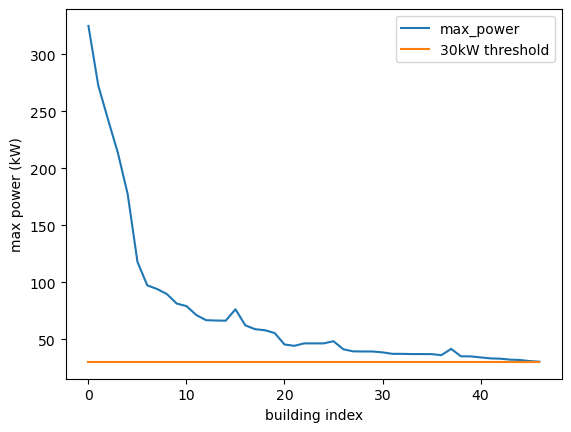

In [360]:
# Tableau du max des puissances pour chaque b√¢timent
max_power = np.zeros(nb_buildings)
for k, building in enumerate(buildings):
    max_power[k] = heat_profile_coeff_tab[k] * np.max(df_tab[categorize(building)].Puissance)
plt.plot(max_power*1e-3, label="max_power")
plt.plot([30 for _ in range(nb_buildings)], label="30kW threshold")
plt.xlabel("building index")
plt.ylabel("max power (kW)")
plt.legend();

In [361]:
mask = np.array([power > 30e3 for power in max_power])
buildings = [buildings[k] for k in range(nb_buildings) if mask[k]]
nb_buildings = len(buildings)
print("Nombre de b√¢timents s√©lectionn√©s apr√®s le deuxi√®me filtrage :", nb_buildings)

Nombre de b√¢timents s√©lectionn√©s apr√®s le deuxi√®me filtrage : 47


Avant de passer au pr√©-d√©coupage et √† l'algorithme, reste √† ajuster le format de `heat_building`.

**NE PAS REEXECUTER CETTE CELLULE**

On ajuste `heat_plant`pour la mettre au bon format.

In [366]:
heat_point = heat_plant["geometry"]["coordinates"]
heat_plant["geometry"]["coordinates"] = []
heat_plant["geometry"]["coordinates"].append([])
heat_plant["geometry"]["coordinates"][0].append([])
heat_plant["geometry"]["coordinates"][0][0].append(heat_point)

On ajoute `heat_plant`√† la fin de notre liste `buildings`filtr√©e.

In [369]:
if len(buildings) == 47:
    del buildings[46]

In [371]:
buildings.append(heat_plant)
nb_buildings = len(buildings)
print(f"Nombre de b√¢timents final : {nb_buildings}")

Nombre de b√¢timents final : 47


## Visualisation du quartier d'int√©r√™t

Nous pouvons enfin visualiser le quartier d'int√©r√™t apr√®s tous les filtrages n√©cessaires :

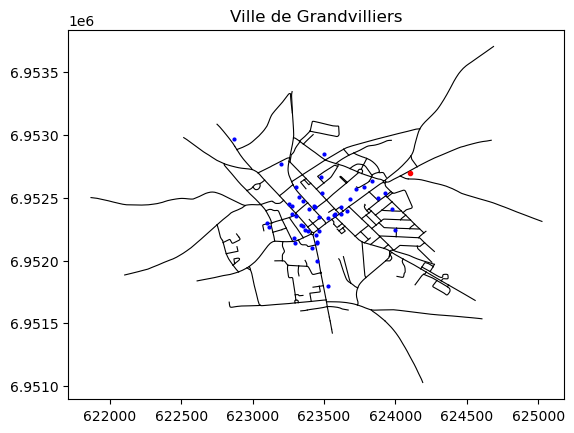

In [373]:
# Trac√© des routes et positionnement des noeuds de route
for road in roads:
    coordinates = road["geometry"]["coordinates"]  # R√©cup√®re les coordonn√©es

    coordinates = [coordinates]  # Transformer en liste pour it√©ration uniforme

    for segment in coordinates:  # It√©rer sur chaque segment de la route
        # Extraire les coordonn√©es (g√©rer 2D ou 3D)
        x_ligne1, y_ligne1 = zip(*[(x, y) for x, y, z in segment])
        
        # Trac√© du segment de la route
        plt.plot(x_ligne1, y_ligne1, color="black", linewidth=0.8)

# Repr√©sentation des b√¢timents par des points
for building in buildings:
    polygon_batiment = shape(building["geometry"])
    # Coordonn√©es du centre du b√¢timent
    centroid = polygon_batiment.centroid
    plt.plot(centroid.x, centroid.y, 'bo', markersize=2)

# Repr√©sentation de l'usine √† chaleur
polygon_plant = shape(heat_plant["geometry"])
centroid_x, centroid_y = polygon_plant.centroid.xy
plt.plot(centroid_x, centroid_y, "ro", markersize=3);

plt.title(f"Ville de {libelle_commune}")
plt.show()

L√©gende :
* Ligne noire: route
* Point bleu: b√¢timent
* Point rouge: usine √† chaleur

### Pr√©paration des routes pour l'algorithme Dijkstra

L'algorithme d'origine parcourt les routes dans leur int√©gralit√©, en suivant la longueur et l'ordre des tron√ßons. Chaque tron√ßon de route est mod√©lis√© par un objet `LineString` de la biblioth√®que `Shapely`, lui-m√™me compos√©e d'une suite de points entre lesquels une droite est trac√©e. Or, dans les donn√©es brutes t√©l√©charg√©es, ces tron√ßons sont ordonn√©es et d√©coup√©es de fa√ßon al√©atoires. Par exemple, une route faisant 1km et ne diposant que d'un seul b√¢timent au d√©but de cette route, dison √† 10m, sera ajout√©e au r√©seau dans son int√©gralit√© si ce b√¢timent est s√©lectionn√© dans le r√©seau. 

D'autre part, dans le logiciel de simulation Dymola, chaque tron√ßon est mod√©lis√© par un tuyau, et chaque tuyau est travers√© par un d√©bit qui d√©pend des ba^timents en amont et en aval. En cons√©quence le mod√®le devient vite compliqu√© vue le nombre des tron√ßons √† mod√©liser dans le mod√®le actuel. Pour que la simulation soit effective, il est n√©cessaire qu'un tron√ßon de route soit unique entre deux b√¢timents √† connecter au r√©seau.


Il s'agit donc dans le code ci-dessous de r√©unir et red√©couper ces routes de sorte √† ce que leurs extr√©mit√©s ne soient plus pos√©es de fa√ßon al√©atoires mais existent si et seulment si elles rencontrent un b√¢timent ou une intersection.

**1<sup>√®re</sup> √©tape : Projection des b√¢timents sur les routes**

On commence par projeter la localisation des b√¢timents sur les routes.

In [381]:
projected_buildings = []

for building in buildings:
    polygon_building = shape(building["geometry"])
    # Coordonn√©es du centre du b√¢timent
    centroid = polygon_building.centroid
    building_point = Point(centroid.x, centroid.y)

    # Trouver la route la plus proche du b√¢timent
    closest_route = None
    min_distance = float("inf")
    for route in roads:
        line = LineString(route["geometry"]["coordinates"])
        distance = line.distance(building_point)
        if distance < min_distance:
            min_distance = distance
            closest_route = line

    # Projeter le point du b√¢timent sur la route la plus proche
    projected_building = closest_route.interpolate(closest_route.project(building_point))
    projected_building = Point(projected_building.x, projected_building.y)
    projected_buildings.append(projected_building)

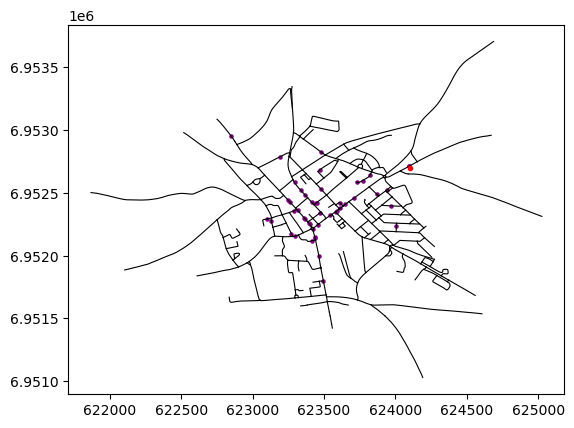

In [383]:
# Trac√© des routes et positionnement des noeuds de route
for road in roads:
    coordinates = road["geometry"]["coordinates"]  # R√©cup√®re les coordonn√©es

    coordinates = [coordinates]  # Transformer en liste pour it√©ration uniforme

    for segment in coordinates:  # It√©rer sur chaque segment de la route
        # Extraire les coordonn√©es (g√©rer 2D ou 3D)
        x_ligne1, y_ligne1 = zip(*[(x, y) for x, y, z in segment])
        
        # Trac√© du segment de la route
        plt.plot(x_ligne1, y_ligne1, color="black", linewidth=0.8)

# Repr√©sentation des b√¢timents par des points
for building in projected_buildings:
    plt.scatter(building.x, building.y, color="purple", s=5, label="B√¢timents projet√©s sur routes")

# Repr√©sentation de l'usine √† chaleur
polygon_plant = shape(heat_plant["geometry"])
centroid_x, centroid_y = polygon_plant.centroid.xy
plt.plot(centroid_x, centroid_y, "ro", markersize=3);

**2<sup>√®me</sup> √©tape : R√©union et d√©coupage des routes**

Pour le moment, les routes sont d√©coup√©es de fa√ßon al√©atoires. Pour visualiser ceci, nous allons affecter de fa√ßon al√©atoire une parmi quatre couleurs √† chaque tron√ßon.

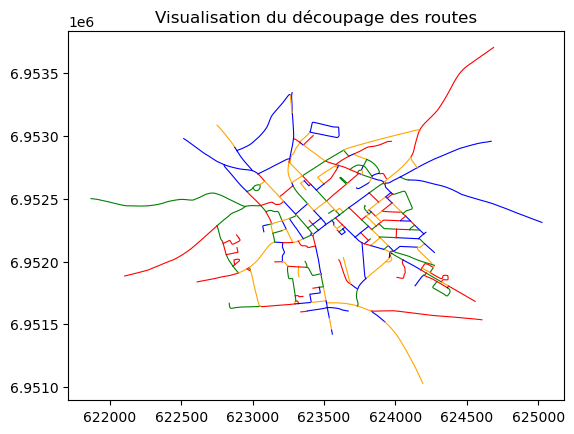

In [385]:
import random

# Liste de couleurs parmi lesquelles choisir
colors = ["blue", "green", "red", "orange"]

# Tracer les routes avec des couleurs al√©atoires
for road in roads:
    coordinates = road["geometry"]["coordinates"]  # R√©cup√®re les coordonn√©es

    coordinates = [coordinates]  # Transformer en liste pour it√©ration uniforme

    # Choisir une couleur al√©atoire pour la route
    color = random.choice(colors)

    for segment in coordinates:  # It√©rer sur chaque segment de la route
        # Extraire les coordonn√©es (g√©rer 2D ou 3D)
        x_ligne1, y_ligne1 = zip(*[(x, y) for x, y, z in segment])
        
        # Trac√© du segment de la route avec la couleur choisie
        plt.plot(x_ligne1, y_ligne1, color=color, linewidth=0.8)

# Ajouter un titre pour clarifier
plt.title("Visualisation du d√©coupage des routes")
plt.show()


*1) R√©union des routes jusque chaque croisement*

In [387]:
from shapely.ops import linemerge

roads_to_linestring =[]

for route in roads:
    line = LineString(route["geometry"]["coordinates"])
    roads_to_linestring.append(line)

# On r√©unit toutes les routes ensemble en un seul objet MultiLineString
multi_line = MultiLineString(roads_to_linestring)

# La commande linemerge permet de r√©unir les routes qui se joignent
merged_roads = linemerge(multi_line)

print(f"Nombre de routes apr√®s r√©union: {len(merged_roads.geoms)}")

Nombre de routes apr√®s r√©union: 307


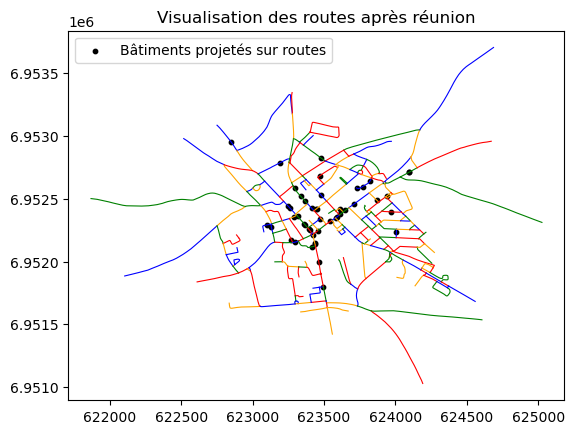

In [388]:
colors = ["blue", "green", "red", "orange"]

# Tracer les routes avec des couleurs al√©atoires
for line in merged_roads.geoms:  # `geoms` contient tous les LineStrings dans le MultiLineString
    color = random.choice(colors)  # Choisir une couleur al√©atoire pour chaque ligne
    x, y = line.xy  # Extraire les coordonn√©es X et Y de la ligne
    plt.plot(x, y, color=color, linewidth=0.8)

# Repr√©sentation des b√¢timents par des points
for building in projected_buildings:
    plt.scatter(building.x, building.y, color="black", s=10, label="B√¢timents projet√©s sur routes")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Ajouter un titre pour clarifier
plt.title("Visualisation des routes apr√®s r√©union")
plt.show()

*2) D√©coupage des routes au niveau des projections des b√¢timents*

In [390]:
def split_routes(merged_connected_roads, projected_buildings2, safety_distance=10):
    split_connected_roads = []

    if isinstance(merged_connected_roads, LineString):
        routes = [merged_connected_roads]
    else:
        routes = list(merged_connected_roads.geoms)

    for route in routes:
        if len(route.coords[0]) == 3:  # Cas o√π la coordonn√©e contient (x, y, z)
            route = LineString([(x, y) for x, y, z in route.coords])  # Ignorer le z
        elif len(route.coords[0]) == 2:  # Cas o√π la coordonn√©e contient (x, y)
            route = LineString([(x, y) for x, y in route.coords])  # Garde seulement (x, y)
        else:
            # Si les coordonn√©es n'ont ni 2 ni 3 √©l√©ments, on peut ignorer la route
            print(f"Route avec coordonn√©es inattendues: {route.coords}")
            continue

        # V√©rifier si des points sont proches de la route, mais √† une distance suffisante des extr√©mit√©s
        no_points_nearby = True
        for point in projected_buildings2:
            distance_to_route = point.distance(route)
            distance_to_start = point.distance(Point(list(route.coords)[0]))
            distance_to_end = point.distance(Point(list(route.coords)[-1]))

            # Si le point est proche de la route mais loin des extr√©mit√©s, nous allons d√©couper la route
            if distance_to_route < 10 and (distance_to_start > safety_distance and distance_to_end > safety_distance):
                no_points_nearby = False
                break  # Sortir de la boucle d√®s qu'un point valide est trouv√©

        # Si aucun point n'est proche de la route, ajouter la route sans modification
        if no_points_nearby:
            split_connected_roads.append(route)
            continue

        # R√©cup√©rer les points proches de la route
        points_in_route = [point for point in projected_buildings2 if point.distance(route) < 10]
        points_in_route.insert(0, Point(list(route.coords)[0]))  # Ajouter le d√©but de la route
        points_in_route.append(Point(list(route.coords)[-1]))  # Ajouter la fin de la route

        if len(points_in_route) > 2:
            # Trier les points par distance croissante par rapport au d√©but de la route
            points_in_route = sorted(points_in_route, key=lambda p: route.project(p))

            # Diviser la route en segments successifs
            previous_position = 0
            last_segment_coords = []  # Liste pour stocker le dernier segment

            for i, point in enumerate(points_in_route):
                current_position = route.project(point)

                # Extraire les coordonn√©es du segment de la position pr√©c√©dente √† la position actuelle
                segment_coords = [
                    coord for coord in route.coords
                    if route.project(Point(coord)) >= previous_position
                    and route.project(Point(coord)) <= current_position
                ]

                # Si ce n'est pas le premier segment, ajoutez le dernier point du segment pr√©c√©dent
                if i != 0:
                    segment_coords.insert(0, last_segment_coords[-1])  # Ajouter le dernier point du segment pr√©c√©dent

                # Ajouter le point de division pour √©viter les trous
                segment_coords.append((point.x, point.y))

                # V√©rifier que le segment contient plus de 1 point avant de cr√©er le LineString
                if len(segment_coords) > 1:
                    segment = LineString(segment_coords)
                    split_connected_roads.append(segment)

                # Mettre √† jour la position pr√©c√©dente et m√©moriser le dernier segment
                previous_position = current_position
                last_segment_coords = segment_coords

            # Ajouter le dernier segment entre le dernier point et la fin de la route
            final_segment_coords = [
                coord for coord in route.coords
                if route.project(Point(coord)) >= previous_position
            ]

            # Ajouter la derni√®re coordonn√©e pour s'assurer que le dernier point est inclus
            if route.coords[-1] not in final_segment_coords:
                final_segment_coords.append(route.coords[-1])

            # V√©rification si final_segment_coords contient plus de 1 point avant de cr√©er le segment
            if len(final_segment_coords) > 1:
                final_segment = LineString(final_segment_coords)
                split_connected_roads.append(final_segment)

        for road in split_connected_roads:
            if road.length == 0 : #On retire les routes de longueur quasi nulle
                split_connected_roads.remove(road)
        
    return split_connected_roads

split_roads = split_routes(merged_roads, projected_buildings, safety_distance=10)

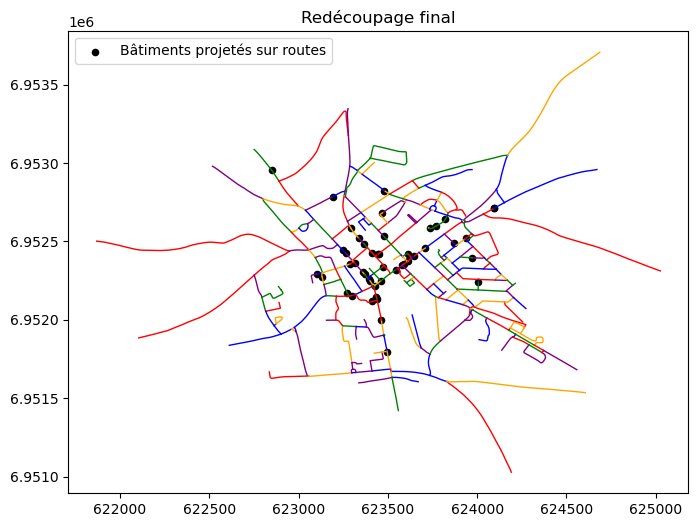

In [391]:
fig, ax = plt.subplots(figsize=(8, 6))

colors = ["blue", "green", "red", "orange", "purple"]

# Tracer les routes avec des couleurs al√©atoires
for route in split_roads:  # `geoms` contient tous les LineStrings dans le MultiLineString
    color = random.choice(colors)  # Choisir une couleur al√©atoire pour chaque ligne
    x, y = zip(*route.coords)  # S√©paration des coordonn√©es x et y
    ax.plot(x, y, color=color, linewidth=1)  # Trac√© en vert pour les routes connect√©es

# Repr√©sentation des b√¢timents par des points
for building in projected_buildings:
    ax.scatter(building.x, building.y, color="black", s=20, label="B√¢timents projet√©s sur routes")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Ajouter un titre pour clarifier
plt.title("Red√©coupage final")
plt.show()

*3) Conversion des routes en objet GeoJSON*

In [394]:
from shapely.geometry import mapping

final_roads = []

for line in split_roads:
    geojson_geometry = mapping(line)
    
    # √âtape 3 : Cr√©er l'objet Feature sans propri√©t√©s
    feature = fiona.model.Feature(
        geometry=geojson_geometry,
        properties={}  # Dictionnaire vide pour les propri√©t√©s
    )
    final_roads.append(feature)

In [395]:
nb_roads = len(final_roads)
print(f"Nombre de routes apr√®s d√©coupage : {nb_roads}")

Nombre de routes apr√®s d√©coupage : 351


## Trac√© du RCU

### D√©finition des noeuds

On d√©finit deux types de noeuds qui poss√©dent de nombreuses propri√©t√©s de trois types : topologiques, √©nerg√©tiques et relatives au r√©seau de chaleur. On compte comme type de noeud :
* Les b√¢timents
* Les routes
* Le plus grand consommateur

Une telle repr√©sentation permet de grandement simplifier l'√©criture du code.

In [399]:
nb_buildings = len(buildings)

In [400]:
class Node_building:
    # Un b√¢timent sera repr√©sent√© par un indice et l'objet b√¢timent qui y est associ√©
    def __init__(self, index, lambda_):
        self.index = index
        self.building = buildings[index]
        self.coordinates = self.building["geometry"]["coordinates"][0][0]
        x, y = zip(*self.coordinates)
        self.center = (np.mean(x), np.mean(y))
        self.type = "batiment"
        self.predecessor = None
        properties = self.building["properties"]
        self.heat_demand = heat_demands[index]
        self.radius = self.heat_demand / lambda_
        self.construction_date = properties["ffo_bat_annee_construction"]
        self.heat_profile_coeff = heat_profile_coeff_tab[index]

class Node_road:
    def __init__(self, index):
        self.index = index
        self.road = final_roads[index]

        # R√©cup√©rer les coordonn√©es brutes
        raw_coordinates = self.road["geometry"]["coordinates"]

        # V√©rifier si c'est une structure 2D ou 3D, ou un type inattendu
        if isinstance(raw_coordinates[0], (list, tuple)):
            self.coordinates = [
                (coord[0], coord[1]) if len(coord) >= 2 else (coord[0], 0)
                for coord in raw_coordinates
                if isinstance(coord, (list, tuple))  # V√©rifie que coord est une liste ou un tuple
            ]
        else:
            # Si la structure est une seule ligne
            self.coordinates = [
                (raw_coordinates[0], raw_coordinates[1]) if len(raw_coordinates) >= 2 else (raw_coordinates[0], 0)
            ]

        # V√©rifier si des coordonn√©es valides ont √©t√© trouv√©es
        if not self.coordinates:
            raise ValueError(f"Aucune coordonn√©e valide trouv√©e pour la route √† l'index {index}. "
                             f"Donn√©es initiales : {self.road['geometry']['coordinates']}")

        # Calcul du centre
        x, y = zip(*self.coordinates)
        self.center = (np.mean(x), np.mean(y))
        self.type = "route"

        self.predecessor = None
        self.length = shape(self.road["geometry"]).length

class Node_plant:
    # L'usine √† chaleur sera repr√©sent√© par un indice et l'objet b√¢timent qui y est associ√©e
    # Diff√©rence avec les noeuds b√¢timents : ni demande en chaleur ni rayon caract√©ristique, index = nb_buildings pour le distinguer et ce sera le dernier dans les listes
    def __init__(self, heat_plant=heat_plant):
        self.index = nb_buildings
        self.building = heat_plant
        self.coordinates = heat_plant["geometry"]["coordinates"][0][0]
        x, y = zip(*(self.coordinates))
        self.center = (np.mean(x), np.mean(y))
        self.type = "production de chaleur"
        self.predecessor = None

### Mod√©lisation des ar√™tes

La pr√©sence d'une ar√™te entre deux noeuds signifie qu'un tuyau peut joindre directement ces derniers en suivant la route et sans croiser de noeud interm√©diaire. Il y a ainsi deux types de noeuds :
* Entre deux tron√ßons de routes successifs;
* Entre un b√¢timent et une route qui lui est proche.

Nous avons fait le choix de ne raccorder que depuis la route les b√¢timents, on exclut donc la possibilit√© de r√©aliser des tuyaux entre les habitations. Il y aura donc √©ventuellement une l√©g√®re surestimation du co√ªt du r√©seau de chaleur qu'il faudra prendre en compte lors de la pr√©sentation du projet.

Les ar√™tes seront mod√©lis√©es par des tables d'adjacence repr√©sent√©es par des dictionnaires Python. Il s'agit certes de structures redondantes, mais nous les avons choisi pour leur grande efficacit√© en terme de temps de calcul. L'encombrement m√©moire ne repr√©sentera par ailleurs pas un probl√®me √©tant donn√©e la faible taille du graphe √©tudi√© (de l'odre du millier de noeuds).

### Construction du graphe

Les r√®gles sont les suivantes pour calculer les ar√™tes :
1. Deux routes sont connect√©es si et seulement si la distance minimale entre ces derni√®res est inf√©rieure √† 5m;
2. Un b√¢timent est connect√© √† sa route la plus proche.

In [405]:
class Graph:

    def __init__(self, list_nodes_buildings, list_nodes_roads, list_edges_buildings, list_edges_roads, list_edges_roads_buildings):
        self.list_nodes_buildings = list_nodes_buildings
        self.list_nodes_roads = list_nodes_roads
        self.list_edges_buildings = list_edges_buildings
        self.list_edges_roads = list_edges_roads
        self.list_edges_roads_buildings = list_edges_roads_buildings
        self.nb_buildings = len(self.list_nodes_buildings) - 1
        self.nb_roads = len(self.list_nodes_roads)
        self.dhn_roads = np.full(self.nb_roads, False) # DHN : district heat network
        self.dhn_buildings = np.full(self.nb_buildings, False)
        self.radii = np.zeros(nb_buildings)
        self.network_radius = 0
        self.loop_test = False

    def initialise_radii(self):
        """
        R√©initialise la liste interne au graphe aux valeurs des rayons des b√¢timents
        """
        for building in self.list_nodes_buildings[:-1]:
            self.radii[building.index] = building.radius

    def connect_network(self, building, verbose=False):
        """
        Connecte building depuis l'usine √† chaleur en remontant le plus court chemin
        gr√¢ce aux pr√©decesseurs (calcul√©s en amont de cette fonction avec shortest_way !)
        """
        node = building.predecessor
        # Indiquer le b√¢timent comme connect√©
        if node == None:
            self.dhn_buildings[building.index] = False
        else:
            self.dhn_buildings[building.index] = True
            # Trouver la rue connect√©e √† building situ√©e sur le plus court chemin entre building et l'usine √† chaleur
            while node.type != "production de chaleur":
                if node.type == 'route':
                    if verbose and not self.dhn_roads[node.index]:
                    # On remonte le plus court chemin jusqu'√† revenir √† building
                        self.dhn_roads[node.index] = True
                node = node.predecessor

    def reinitialise_predecessors(self):
        """
        R√©initialise les attributs 'predecessor' de tous les noeuds
        """
        for building in self.list_nodes_buildings:
            building.predecessor = None
        

    def shortest_way(self, initial_builing, list_buildings, verbose=False):
        """
        Calcule les plus petits chemins entre initial_building et les √©l√©ments
        de liste_building
        """
        verbose = False
        # Algorithme de Djikstra, termine lorsque les batiments de liste_batiments ont √©t√© parcourus
        # R√©initialisation des pr√©decesseurs
        self.reinitialise_predecessors()
        # Initialisation
        list_index = [building.index for building in list_buildings]
        distances_buildings = np.full(self.nb_buildings + 1, np.inf)
        distances_roads = np.full(self.nb_roads, np.inf)
        buildings_to_cross = np.full(self.nb_buildings + 1, True)
        roads_to_cross = np.full(self.nb_roads, True)
        
        distances_buildings[initial_builing.index] = 0

        # It√©rations - tant que les batiments de list_buildings n'ont pas tous √©t√© parcourus
        while np.any(buildings_to_cross[list_index]):
            # Nous allons calculer le noeud de plus petite distance en comparant celui de type Node_building et celui de type Node_road (tous deux de plus petite distance par rapport √† leurs semblables)

            # Il reste n√©cessairement des noeuds de b√¢timents √† parcourir
            # On choisit le noeud non parcouru de plus petite distance de type b√¢timent
            mask_buildings = buildings_to_cross & (distances_buildings == np.min(distances_buildings[buildings_to_cross])) # tableau de bool√©ens dont les composantes valent True ssi le b√¢timent n'a pas √©t√© parcouru et est de plus petite distance
            index_building = np.argmax(mask_buildings) # Calcule l'indice de la premi√®re occurence de True dans le tableau pr√©c√©dent
            # On stocke la distance correspondante
            minimal_distance_buildings = distances_buildings[index_building] 

            # S'il reste des noeuds de routes √† parcourir
            if np.any(roads_to_cross):
                # On choisit le noeud non parcouru de plus petite distance de type route
                mask_roads = roads_to_cross & (distances_roads == np.min(distances_roads[roads_to_cross]))
                index_road = np.argmax(mask_roads)
                minimal_distance_roads = distances_roads[index_road]
                # test = "Le noeud non parcouru de plus petite distance est-il un b√¢timent ?"
                test = minimal_distance_buildings <= minimal_distance_roads
            # S'il n'y a plus de routes √† parcourir, alors on dit que test est vrai pour parcourir le noeud b√¢timent de plus petite distance
            else :
                test = True
            
            # CAS 1 : le noeud de plus petite distance est un b√¢timent
            if test:
                # current_building est le b√¢timent correspondant √† cette distance
                current_building = self.list_nodes_buildings[index_building]
                # On l'indique comme parcouru
                buildings_to_cross[index_building] = False
                # On parcourt les noeuds voisins non parcourus (routes)
                for road, length in self.list_edges_buildings[index_building]:
                    # On teste si le noeud n'a pas √©t√© parcouru
                    if roads_to_cross[road.index]:
                        # Minimisation du chemin
                        new_distance = distances_buildings[index_building] + length
                        if distances_roads[road.index] > new_distance:
                            distances_roads[road.index] = new_distance
                            road.predecessor = current_building
            
            # CAS 2 : le noeud de plus petite distance est une route
            else:
                # current_road est la route correspondant √† cette distance
                current_road = self.list_nodes_roads[index_road]
                # On l'indique comme parcourue
                roads_to_cross[index_road] = False
                # On d√©termine la longueur de tuyaux √† ajouter sur la route actuelle
                if self.dhn_roads[current_road.index]:
                    length_road = 0
                else:
                    length_road = current_road.length
                # On parcourt les routes voisines non parcourues
                for road in self.list_edges_roads[index_road]:
                    if roads_to_cross[road.index]:
                        # Minimisation du chemin
                        new_distance = distances_roads[index_road] + length_road
                        if distances_roads[road.index] > new_distance:
                            distances_roads[road.index] = new_distance
                            road.predecessor = current_road
                # On parcourt les batiments voisins non parcourus
                for building, length in self.list_edges_roads_buildings[index_road]:
                    if buildings_to_cross[building.index]:
                        # Minimisation du chemin
                        new_distance = distances_roads[index_road] + length + length_road
                        if distances_buildings[building.index] > new_distance:
                            distances_buildings[building.index] = new_distance
                            building.predecessor = current_road

        result = {list_index[k]: distances_buildings[building.index] for k in range(len(list_index))}
        return result
      
            
    def compute_dhn(self, verbose=False):
        """
        Calcule le trac√© du r√©seau de chaleur urbain
        """
        # Initialisation de la file de parcours des b√¢timents, dans l'ordre de la conso √©nerg√©tique d√©croissante
        self.queue = list(np.arange(self.nb_buildings))
        # Initialisation d'une liste pour savoir quels b√¢timents ont d√©j√† √©t√© parcourus
        self.were_crossed_buildings = np.full(self.nb_buildings, 0)
        # R√©initialisation des rayons
        self.initialise_radii()
        self.network_radius = 0
        # R√©initialisation du r√©seau de chaleur
        self.dhn_buildings = np.full(self.nb_buildings + 1, False)
        self.dhn_roads = np.full(self.nb_roads, False)
        # Le r√©seau est initialis√© au noeud du plus grand consommateur
        self.dhn_buildings[-1] = True
        # On parcourt tous les b√¢timents (hors usine √† chaleur)
        while len(self.queue) > 0:
            # On prend le premier b√¢timent dans la file d'attente
            index = self.queue[0]
            current_building = self.list_nodes_buildings[index]
            # Calcule sa distance au r√©seau de chaleur
            distance_network = self.shortest_way(self.list_nodes_buildings[-1], [current_building], verbose=verbose)[index]
            # Si le raccord est √©conomiquement viable, on l'effectue
            if self.radii[index] + self.network_radius >= distance_network:
                # Raccord
                self.connect_network(current_building, verbose=verbose)
                # Actualisation du rayon du r√©seau de chaleur
                self.network_radius += self.radii[index] - distance_network
                # On indique que le dernier b√¢timent a avoir √©t√© raccord√© l'a √©t√© apr√®s x tentatives
                self.loop_test = self.were_crossed_buildings[index]
            # Sinon, on remet le b√¢timent au fond de la file √† condition qu'un b√¢timent a √©t√© connect√© lors de la derni√®re boucle
            elif self.loop_test >= self.were_crossed_buildings[index] - 1:
                # Ajout √† la file
                self.queue.append(index)
                # On indique que le b√¢timent a √©t√© parcouru une fois de plus
                self.were_crossed_buildings[index] += 1
            # Dernier cas, le b√¢timent ne sera pas raccord√© au r√©seau
            else:
                pass
            # On retire current_building de la file
            self.queue.pop(0)

In [407]:
###### DEFINITION DES FONCTIONS

#Extraction des routes
def extract_connected_routes(G):
    connected_routes = []  
        
    for road in G.list_nodes_roads:
        if G.dhn_roads[road.index]: # Si la route est connect√©e
            x_coords, y_coords = zip(*road.coordinates)
            connected_routes.append(LineString(zip(x_coords, y_coords)))
    return connected_routes

#Extraction des b√¢timents
def extract_connected_buildings(G):
    connected_buildings = []  
    
    for index in range(G.nb_buildings):  # Parcourt tous les b√¢timents sauf l'usine
        if G.dhn_buildings[index]:  # Si le b√¢timent est connect√©
            building = G.list_nodes_buildings[index]
            building_info = {
                "index": building.index,              # Index du b√¢timent
                "geometry": building.building["geometry"],  # G√©om√©trie du b√¢timent
                "center": building.center,            # Coordonn√©es du centre
                "heat_demand": building.heat_demand,  # Demande de chaleur du b√¢timent
                "construction_date": building.construction_date,
                "heat_profile_coeff": building.heat_profile_coeff,
            }
            connected_buildings.append(building_info) 
    return connected_buildings

#Longueur du r√©seau
def get_total_dhn_length(connected_routes):
    total_length = 0

    for route in connected_routes:
        # Cr√©er une ligne √† partir des coordonn√©es du tron√ßon
        line = LineString(route)
        
        # Ajouter la longueur du tron√ßon √† la longueur totale
        total_length += line.length

    return total_length
 
#Demande en chaleur couverte
def get_dhn_heat_demand(connected_buildings):
    total_demand = 0  # Initialisation de la consommation totale
    
    for building in connected_buildings:
        total_demand += building["heat_demand"]  # Ajoute la demande de chaleur de chaque b√¢timent

    return total_demand

In [408]:
def Dijkstra_Algorithm(lambda_):
    # Liste des noeuds b√¢timents
    list_nodes_buildings = [Node_building(index, lambda_) for index in range(0, nb_buildings)] + [Node_plant(heat_plant)]
    # Liste des noeuds routes
    list_nodes_roads = [Node_road(index) for index in range(nb_roads)]
    # Liste des ar√™tes entre les routes initialis√©e vide
    list_edges_roads = {road.index : [] for road in list_nodes_roads}
    # Liste des ar√™tes entre routes et b√¢timents initialis√©e vide
    list_edges_buildings = {building.index : [] for building in list_nodes_buildings}
    # Liste des ar√™tes entre routes et b√¢timents, mais dans l'autre sens
    list_edges_roads_buildings = {road.index : [] for road in list_nodes_roads}

    
    # Relier les routes entre elles √† 5m pr√®s
    for road1 in list_nodes_roads:
        for road2 in list_nodes_roads[road1.index+1:]:
            if road2 != road1:
                line1 = LineString(road1.coordinates)
                line2 = LineString(road2.coordinates)
        
                # On relie si cette distance est inf√©rieure √† 5m
                if line1.distance(line2) <= 5:
                    list_edges_roads[road1.index].append(road2)
                    list_edges_roads[road2.index].append(road1)
                
    # Relier les b√¢timents et l'usine √† chaleur √† la route la moins √©loign√©e
    for building in list_nodes_buildings:
        is_connected = False
        closest_road = list_nodes_roads[0]
        closest_road_distance = 10000
        for road in list_nodes_roads:
    
            point1 = Point(building.center)
            line2 = LineString(road.coordinates)

            # Calculer la distance minimale entre le b√¢timent et la route
            minimal_distance = point1.distance(line2)
    
            if minimal_distance < closest_road_distance:
                closest_road_distance = minimal_distance
                closest_road = road
            
        # On connecte √† la route la plus proche
        list_edges_buildings[building.index].append((closest_road, closest_road_distance))
        list_edges_roads_buildings[closest_road.index].append((building, closest_road_distance))

    G = Graph(list_nodes_buildings, list_nodes_roads, list_edges_buildings, list_edges_roads, list_edges_roads_buildings)
    G.compute_dhn(verbose=True)
    
    # On r√©cup√®re les routes
    connected_routes = extract_connected_routes(G)  
    
    # On r√©cup√®re les b√¢timents
    connected_buildings = extract_connected_buildings(G)

    return connected_routes, connected_buildings

### Optimisation

On d√©finit les fonctions d'optimisation avec cr√©ation des noeuds extr√©maux, et s√©lection puis suppression des routes extr√©males.

In [410]:
## DECOUPAGE
def project_buildings(connected_routes, connected_buildings):

    projected_buildings = []

    # Cr√©er un MultiLineString √† partir des routes
    multiline = MultiLineString([LineString(route) for route in connected_routes])
    
    for building in connected_buildings:
        building_point = Point(building["center"])
    
        # Trouver la route la plus proche du b√¢timent
        closest_route = None
        min_distance = float("inf")
        for route in connected_routes:
            line = LineString(route)
            distance = line.distance(building_point)
            if distance < min_distance:
                min_distance = distance
                closest_route = line
    
        # Projeter le point du b√¢timent sur la route la plus proche
        projected_point = closest_route.interpolate(closest_route.project(building_point))
        projected_buildings.append(projected_point)

    return projected_buildings

def cut_dhn_roads(merged_connected_roads, projected_buildings):
    from shapely.geometry import mapping
    
    split_connected_roads = split_routes(merged_connected_roads, projected_buildings, safety_distance=10)
    
    # Liste pour stocker les routes finalis√©es avec leurs propri√©t√©s
    final_connected_roads = []
    
    # Boucle pour traiter les routes
    for road in split_connected_roads:
        geojson_geometry = mapping(road)  # Conversion en GeoJSON
    
        # Cr√©er les propri√©t√©s avec les informations suppl√©mentaires
        properties = {
            "geometry": geojson_geometry,  # G√©om√©trie de la route
            "code_commune": code_comm_insee,  # Code de la commune
            "longueur": road.length           # Longueur de la route
        }
        
        # Cr√©ation de l'objet Feature avec ses propri√©t√©s
        feature = fiona.model.Feature(
            geometry=geojson_geometry,
            properties=properties
        )
    
        # Ajouter l'objet Feature √† la liste
        final_connected_roads.append(feature)

    connected_routes = []

    for route in final_connected_roads:
        line = LineString(route["geometry"]["coordinates"])
        connected_routes.append(line)

    return connected_routes

In [411]:
## FONCTIONS
class Node:
    def __init__(self, index, coordinates, node_type):
        self.index = index  # ID unique
        self.coordinates = coordinates  # Coordonn√©es (x, y)
        self.type = node_type  # Type de n≈ìud, ex: "route", "b√¢timent"
        self.predecessor = None  # Attribut pour stocker le pr√©d√©cesseur, utile pour des algos comme Dijkstra

def create_nodes_from_routes(routes):
    nodes = []
    node_map = {}  # Dictionnaire pour √©viter les doublons (cl√© : tuple(coordonn√©es), valeur : node_id)
    node_id_counter = 0  # Compteur d'ID des n≈ìuds

    for route in routes:
        # V√©rifie que la route est un LineString
        if isinstance(route, LineString):
            # Obtenir les extr√©mit√©s
            start_point = Point(route.coords[0])  # Extr√©mit√© de d√©but
            end_point = Point(route.coords[-1])  # Extr√©mit√© de fin

            # Ajouter les points aux n≈ìuds, en √©vitant les doublons
            for point in [start_point, end_point]:
                coord = (point.x, point.y)
                if coord not in node_map:
                    # Si le point est unique, cr√©er un nouveau n≈ìud
                    node = Node(node_id_counter, coord, "route")
                    nodes.append(node)
                    node_map[coord] = node_id_counter
                    node_id_counter += 1

    return nodes


def is_near_multiple_routes(point, routes, tolerance):
        count = 0
        previous_route = None  # Pour m√©moriser la route pr√©c√©dente proche du point
    
        for route in routes:
            # V√©rifier qu'il s'agit d'une route et pas juste d'un point
            if route.length == 0:
                continue
            # V√©rifier si la route est proche du point
            if point.distance(route) < tolerance:
                # Si une route pr√©c√©dente existe, v√©rifier la superposition de deux coordonn√©es ou plus
                if previous_route:
                    # Comparer les coordonn√©es des deux routes
                    common_coords = set(route.coords).intersection(set(previous_route.coords))
                    if len(common_coords) >= 2:  # Si deux coordonn√©es ou plus sont partag√©es
                        continue  # Ignorer cette route (ne pas l'inclure dans le comptage)
                
                # Si aucune route pr√©c√©dente ou si aucune superposition, on ajoute √† `count`
                count += 1
                previous_route = route  # Mettre √† jour la route pr√©c√©dente
    
            # Si au moins deux routes sont proches du point, on arr√™te et on retourne True
            if count >= 2:
                return True
    
        return False 


def create_extremal_nodes(nodes, connected_routes, projected_buildings):
    internal_nodes = []
    
    from shapely.geometry import LineString, Point
    
    for node in nodes:
        node_point = Point(node.coordinates)
        if is_near_multiple_routes(node_point, connected_routes, 5):
            internal_nodes.append(node)
    
    extremal_nodes = [node for node in nodes if node not in internal_nodes]
    extremal_nodes = [node for node in extremal_nodes if all(Point(node.coordinates).distance(point)>10 for point in projected_buildings)]
    
    return extremal_nodes

def select_extremal_routes(connected_routes, extremal_nodes):
    extremal_routes = []

    # Pour chaque n≈ìud dans la liste des n≈ìuds
    for node in extremal_nodes:
        node_point = Point(node.coordinates)  # Convertir le n≈ìud en Point
    
        # Filtrer les routes pour celles qui contiennent ou touchent le n≈ìud
        filtered_routes = [
            route for route in connected_routes
            if isinstance(route, LineString) and route.intersects(node_point) and route.length > 0  # V√©rifie si le Point est sur la LineString
        ]
        
        # S√©lectionner la premi√®re route correspondante
        matching_route = filtered_routes[0] if filtered_routes else None
        extremal_routes.append(matching_route)

    return extremal_routes

def optimized_dhn_roads(connected_routes, extremal_routes):
    dhn_roads = []

    for route in connected_routes:
        if route not in extremal_routes: # On ne conserve que les routes non extr√©males
            dhn_roads.append(route)
            
    return dhn_roads

In [412]:
## OPTIMISATION
def optimization(connected_routes, connected_buildings):
    projected_buildings2 = project_buildings(connected_routes, connected_buildings)
    merged_connected_roads = linemerge(MultiLineString(connected_routes))
    connected_routes = cut_dhn_roads(merged_connected_roads, projected_buildings2)

    nodes = create_nodes_from_routes(connected_routes)
    extremal_nodes = create_extremal_nodes(nodes, connected_routes, projected_buildings2)
    extremal_routes = select_extremal_routes(connected_routes, extremal_nodes)

    dhn_roads = optimized_dhn_roads(connected_routes, extremal_routes)

    return dhn_roads

### Optimal lambda

L'optimisation est int√©gr√©e dans la recherche du lambda optimal ici.

In [414]:
import numpy as np

#LAMBDA OPTIMAL
max_linear_density = 0
for lambda_ in tqdm(np.arange(0.1e3, 1.6e3, 0.1e3), desc="Progression", unit="lambda_"):
    #Extraire les routes et les b√¢timents du r√©seau
    connected_routes, connected_buildings = Dijkstra_Algorithm(lambda_)
    connected_routes = optimization(connected_routes, connected_buildings)
    
    #Densit√© lin√©ique
    dhn_length = get_total_dhn_length(connected_routes)
    if dhn_length > 0:
        dhn_heat_supply = get_dhn_heat_demand(connected_buildings)
        linear_density = dhn_heat_supply/dhn_length
        #if (linear_density > max_linear_density) and (len(connected_buildings) > 9): # Contrainte √† plus de 10 b√¢timents
        if (linear_density > max_linear_density):
            max_linear_density = linear_density
            optimal_lambda = lambda_

print(optimal_lambda)
print(max_linear_density)

Progression:   0%|                                                                         | 0/15 [00:00<?, ?lambda_/s]C:\Users\charl\anaconda3\Lib\site-packages\shapely\measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
C:\Users\charl\anaconda3\Lib\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
Progression: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 15/15 [02:48<00:00, 11.20s/lambda_]

1400.0
2596.491372527474


In [415]:
connected_routes, connected_buildings = Dijkstra_Algorithm(optimal_lambda)
connected_routes = optimization(connected_routes, connected_buildings)

### Visualisation du graphe

Il est important de visualiser r√©guli√®rement ce que l'on fait afin d'√©viter toute aberration.

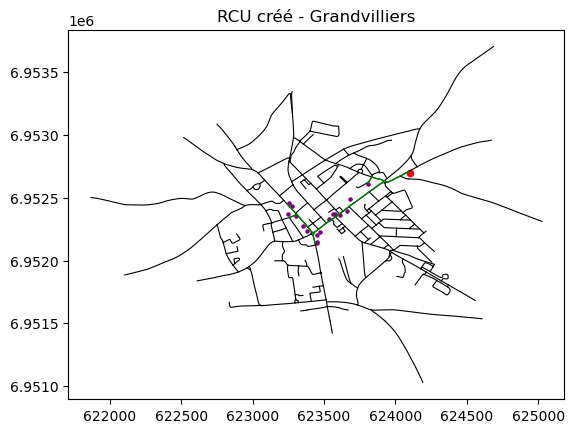

In [418]:
for road in roads:
    coordinates = road["geometry"]["coordinates"]  # R√©cup√®re les coordonn√©es

    coordinates = [coordinates]  # Transformer en liste pour it√©ration uniforme

    for segment in coordinates:  # It√©rer sur chaque segment de la route
        # Extraire les coordonn√©es (g√©rer 2D ou 3D)
        x, y = zip(*[(x, y) for x, y, z in segment])
        
        # Trac√© du segment de la route
        plt.plot(x, y, color="black", linewidth=0.8)

for route in connected_routes:
    x, y = zip(*route.coords)  # S√©paration des coordonn√©es x et y
    plt.plot(x, y, color="green", linewidth=1, label="Routes connect√©es")  # Trac√© en vert pour les routes connect√©es

# Trac√© des n≈ìuds cr√©√©s (en bleu)
for building in connected_buildings:
    x, y = building["center"]  # Coordonn√©es extraites du champ 'center'
    plt.scatter(x, y, color="purple", s=5, label="B√¢timents connect√©s")

heat_plant_coords = Point(heat_plant["geometry"]["coordinates"][0][0][0])
plt.scatter(heat_plant_coords.x, heat_plant_coords.y, color="red", s=20, label="Usine √† chaleur")

plt.title(f"RCU cr√©√© - {libelle_commune}")
plt.show()

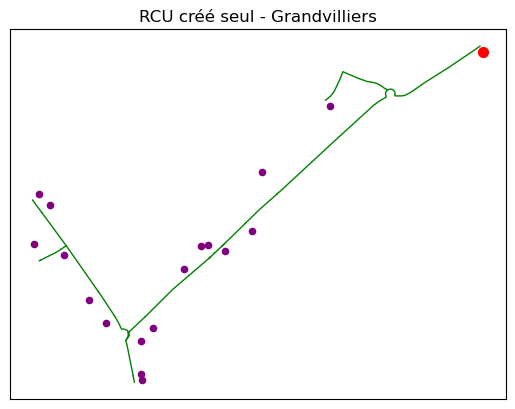

In [419]:
for route in connected_routes:
    x, y = zip(*route.coords)  # S√©paration des coordonn√©es x et y
    plt.plot(x, y, color="green", linewidth=1, label="Routes connect√©es")  # Trac√© en vert pour les routes connect√©es

# Trac√© des n≈ìuds cr√©√©s (en bleu)
for building in connected_buildings:
    x, y = building["center"]  # Coordonn√©es extraites du champ 'center'
    plt.scatter(x, y, color="purple", s=20, label="B√¢timents connect√©s")

heat_plant_coords = Point(heat_plant["geometry"]["coordinates"][0][0][0])
plt.scatter(heat_plant_coords.x, heat_plant_coords.y, color="red", s=50, label="Usine √† chaleur")

plt.title(f"RCU cr√©√© seul - {libelle_commune}")
plt.gca().set_xticks([]) 
plt.gca().set_yticks([])
plt.show()

**Caract√©ristiques du r√©seau :**

In [421]:
import pandas as pd

# Calculs des valeurs
dhn_length = get_total_dhn_length(connected_routes) / 1000
dhn_heat_supply = get_dhn_heat_demand(connected_buildings) / 1e6
total_heat_demand = sum(heat_demands) * 1e-6
heat_coverage_rate = dhn_heat_supply / total_heat_demand
linear_density = get_dhn_heat_demand(connected_buildings) / get_total_dhn_length(connected_routes) / 1000

# Cr√©ation du tableau sous forme de DataFrame
data = {
    "Attribute": [
        "Total heat demand (GWh)",
        "Optimal Lambda (GWh/km)",
        "DHN length (km)",
        "Number of connected buildings",
        "Heat demand covered (GWh)",
        "Heat coverage rate (%)",
        "Linear density (GWh/km)"
    ],
    "Value": [
        f"{total_heat_demand:.2f}",
        f"{optimal_lambda/1000:.2f}",
        f"{dhn_length:.2f}",
        len(connected_buildings),
        f"{dhn_heat_supply:.2f}",
        f"{heat_coverage_rate * 100:.2f}%",
        f"{linear_density:.2f}"
    ]
}

dhn_caracteristics = pd.DataFrame(data)

# Affichage du tableau
print(dhn_caracteristics)

                       Attribute   Value
0        Total heat demand (GWh)    6.88
1        Optimal Lambda (GWh/km)    1.40
2                DHN length (km)    1.49
3  Number of connected buildings      19
4      Heat demand covered (GWh)    3.86
5         Heat coverage rate (%)  56.14%
6        Linear density (GWh/km)    2.60


*Copy-paste*

In [424]:
print(dhn_caracteristics["Value"].to_string(index=False))

  6.88
  1.40
  1.49
    19
  3.86
56.14%
  2.60


### Affichage du r√©seau final

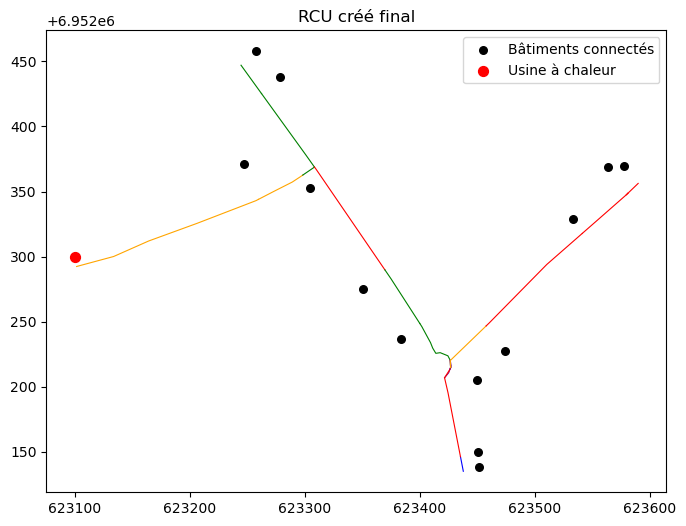

In [127]:
fig, ax = plt.subplots(figsize=(8, 6))

colors = ["blue", "green", "red", "orange", "purple"]

# Tracer les routes avec des couleurs al√©atoires
for line in connected_routes:  # `geoms` contient tous les LineStrings dans le MultiLineString
    color = random.choice(colors)  # Choisir une couleur al√©atoire pour chaque ligne
    x, y = line.xy  # Extraire les coordonn√©es X et Y de la ligne
    ax.plot(x, y, color=color, linewidth=0.8)

# Repr√©sentation des b√¢timents par des points
for building in connected_buildings:
    x, y = building["center"]  # Coordonn√©es du centre du b√¢timent
    ax.scatter(x, y, color="black", s=30, label="B√¢timents connect√©s")  # Points violets pour les b√¢timents

plt.scatter(heat_plant_coords.x, heat_plant_coords.y, color="red", s=50, label="Usine √† chaleur")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Ajouter un titre pour clarifier
plt.title("RCU cr√©√© final")
plt.show()

Ce d√©coupage permet √† chaque tron√ßon d'√™tre manipul√© par un tuyau entre chaque b√¢timent ou chaque croisement. En cons√©quence, il offre une manipulation plus ais√©e dans Dymola.

Reste √† red√©finir de nouveau noeuds et listes de b√¢timents et de routes pour l'application dans Dymola.

In [ ]:
final_dhn_roads = []

for line in connected_routes:
    geojson_geometry = mapping(line)

    
    # √âtape 3 : Cr√©er l'objet Feature sans propri√©t√©s
    feature = fiona.model.Feature(
        geometry = geojson_geometry,
        properties = { 
        "insee_commune_gauche": code_comm_insee,
        "insee_commune_droite": code_comm_insee, # Code de la commune
        "length": road.length           # Longueur de la route
    } 
    )

    final_dhn_roads.append(feature)

### Creation des listes de noeuds pour Dymola:

In [ ]:
class Node_dhn_building:
    # Un b√¢timent sera repr√©sent√© par un indice et l'objet b√¢timent qui y est associ√©
    def __init__(self, index, lambda_):
        self.index = index
        self.building = connected_buildings[index]
        x, y = self.building["center"]
        self.center = (np.mean(x), np.mean(y))
        self.type = "batiment"
        self.predecessor = None
        self.heat_demand = self.building["heat_demand"]
        self.radius = self.heat_demand / lambda_
        self.construction_date = self.building["construction_date"]
        self.heat_profile_coeff = self.building["heat_profile_coeff"]

class Node_dhn_road:
    def __init__(self, index):
        self.index = index
        self.road = final_dhn_roads[index]

        # R√©cup√©rer les coordonn√©es brutes
        raw_coordinates = self.road["geometry"]["coordinates"]

        # V√©rifier si c'est une structure 2D ou 3D, ou un type inattendu
        if isinstance(raw_coordinates[0], (list, tuple)):
            self.coordinates = [
                (coord[0], coord[1]) if len(coord) >= 2 else (coord[0], 0)
                for coord in raw_coordinates
                if isinstance(coord, (list, tuple))  # V√©rifie que coord est une liste ou un tuple
            ]
        else:
            # Si la structure est une seule ligne
            self.coordinates = [
                (raw_coordinates[0], raw_coordinates[1]) if len(raw_coordinates) >= 2 else (raw_coordinates[0], 0)
            ]

        # V√©rifier si des coordonn√©es valides ont √©t√© trouv√©es
        if not self.coordinates:
            raise ValueError(f"Aucune coordonn√©e valide trouv√©e pour la route √† l'index {index}. "
                             f"Donn√©es initiales : {self.road['geometry']['coordinates']}")

        # Calcul du centre
        x, y = zip(*self.coordinates)
        self.center = (np.mean(x), np.mean(y))
        self.type = "route"

        self.predecessor = None
        self.length = shape(self.road["geometry"]).length

class Node_plant:
    # L'usine √† chaleur sera repr√©sent√© par un indice et l'objet b√¢timent qui y est associ√©e
    # Diff√©rence avec les noeuds b√¢timents : ni demande en chaleur ni rayon caract√©ristique, index = nb_buildings pour le distinguer et ce sera le dernier dans les listes
    def __init__(self, heat_plant=heat_plant):
        self.index = nb_dhn_buildings
        self.building = heat_plant
        self.coordinates = heat_plant["geometry"]["coordinates"][0][0]
        x, y = zip(*(self.coordinates))
        self.center = (np.mean(x), np.mean(y))
        self.type = "production de chaleur"
        self.predecessor = None

In [ ]:
nb_dhn_buildings = len(connected_buildings)
nb_dhn_roads = len(final_dhn_roads)

In [ ]:
# Liste des noeuds b√¢timents
list_nodes_dhn_buildings = [Node_dhn_building(index, lambda_) for index in range(0, nb_dhn_buildings)] + [Node_plant(heat_plant)]
# Liste des noeuds routes
list_nodes_dhn_roads = [Node_dhn_road(index) for index in range(nb_dhn_roads)]
# Liste des ar√™tes entre les routes initialis√©e vide
list_edges_dhn_roads = {road.index : [] for road in list_nodes_dhn_roads}
# Liste des ar√™tes entre routes et b√¢timents initialis√©e vide
list_edges_dhn_buildings = {building.index : [] for building in list_nodes_dhn_buildings}
# Liste des ar√™tes entre routes et b√¢timents, mais dans l'autre sens
list_edges_dhn_roads_buildings = {road.index : [] for road in list_nodes_dhn_roads}

# Relier les routes entre elles √† 5m pr√®s
for road1 in list_nodes_dhn_roads:
    for road2 in list_nodes_dhn_roads[road1.index+1:]:

        line1 = LineString(road1.coordinates)
        line2 = LineString(road2.coordinates)

        # Calculer la distance minimale entre les deux routes
        minimal_distance = line1.distance(line2)

        # On relie si cette distance est inf√©rieure √† 5m
        if minimal_distance <= 5:
            list_edges_dhn_roads[road1.index].append(road2)
            list_edges_dhn_roads[road2.index].append(road1)
            
# Relier les b√¢timents et l'usine √† chaleur √† la route la moins √©loign√©e
for building in list_nodes_dhn_buildings:
    is_connected = False
    closest_road = list_nodes_dhn_roads[0]
    closest_road_distance = 10000
    for road in list_nodes_dhn_roads:

        point1 = Point(building.center)
        line2 = LineString(road.coordinates)

        # Calculer la distance minimale entre le b√¢timent et la route
        minimal_distance = point1.distance(line2)

        if minimal_distance < closest_road_distance:
            closest_road_distance = minimal_distance
            closest_road = road
        
    # On connecte √† la route la plus proche
    list_edges_dhn_buildings[building.index].append((closest_road, closest_road_distance))
    list_edges_dhn_roads_buildings[closest_road.index].append((building, closest_road_distance))
    is_connected = True # Ligne inutile mais facilite la lecture

In [ ]:
# Repr√©sentation graphique - batiments en rouge, routes en bleu (points), le tout reli√©. Si c'est assez lisible,
# on ajoutera dans un second temps le trac√© des routes

# Trac√© des routes et positionnement des noeuds de route
for road in list_nodes_dhn_roads:
    # Trac√© des routes
    x_line1, y_line1 = zip(*road.coordinates)
    plt.plot(x_line1, y_line1, color="black", linewidth=0.8)
    # Positionnement des noeuds de route
    plt.scatter(road.center[0], road.center[1], color="green", s=5)

# Positionnement des noeuds de b√¢timents
for building in list_nodes_dhn_buildings:
    x,y = building.center
    if building.type == "production de chaleur":
        plt.scatter(x, y, color="red", s=10)
    else:
        plt.scatter(x, y, color="blue", s=5)

FIN.